## Upload Data Files to Your Jupyter Account and Pack the Data

Below, we have provided a more compact version of the code you used last week to examine your data and then do some averaging to pack it. Once you have saved a set of data from the oscilloscope, and uploaded it to your Jupyter account, the entire code runs in one cell. You will probably need to run it several times until you are satisfied with the final output. The key pieces of code that you will need to alter are indicated by notes in Red, and include:
- the name for your uploaded raw data file `fname`
- the filename you will use to save your packed and trimmed data `output_name`
- the zoomed in flat range you use to examine the noise and measure the standard deviation `indexraw_min` to `indexraw_max`
- the corresponding y-range for the selected region to examine `yregion_min` to `yregion_max`
- (optional) change the way uncertainty is determined from `default` (uses standard deviation of selected region) to `digital` if only occasional bit noise between 2 values appears in the selected region (uses $\frac{max-min}{\sqrt{3}}$), or `manual` and provide a value for `manualsigma` (to use a different, justified value or expression for the uncertainty)
- the number of points you want to average when packing the data `npac`
- to trim unwanted data set the flag `trim` to `1`, and enter `trim_min` and `trim_max` limits of the PACKED indices to include this data only; note if `trim` is set to `0` the full data set will be packed and saved

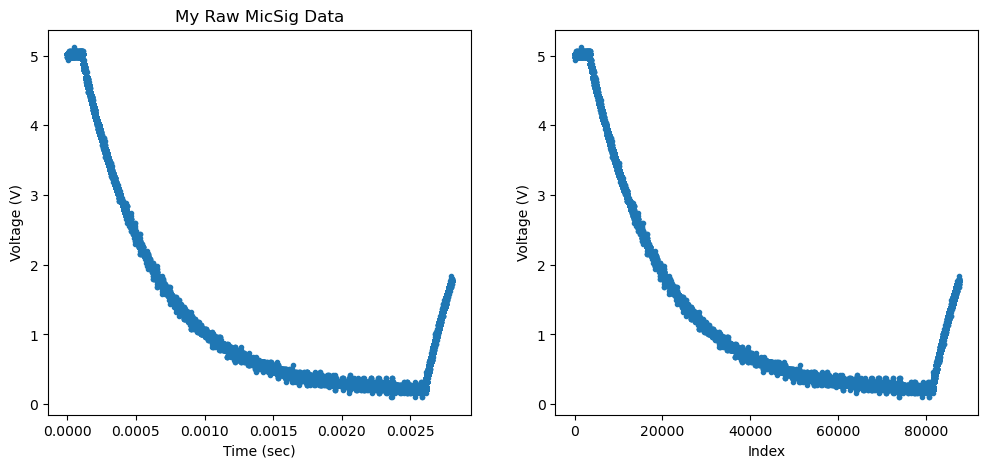

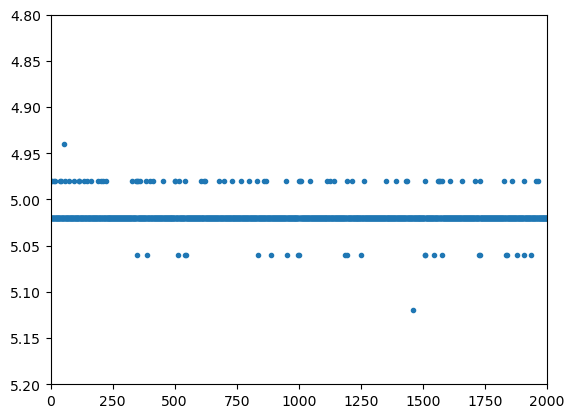

mean =  5.0190699999999975
standard deviation =  0.009128806055558287


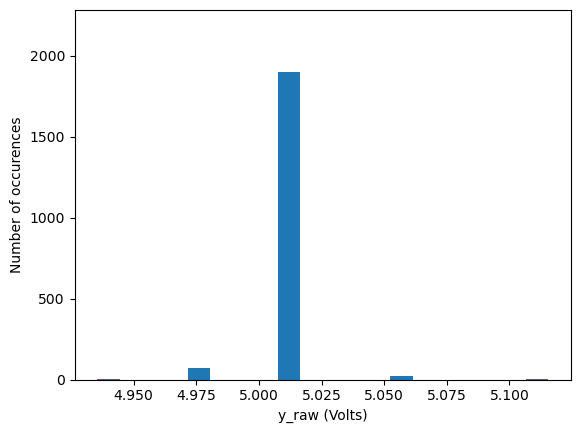

packing is done by averaging 100 data points
packed data contains full data set


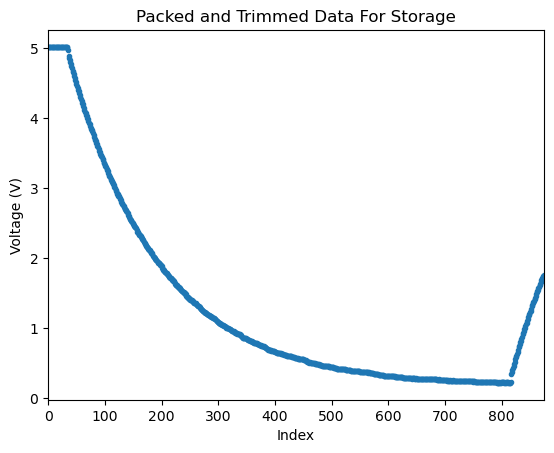

Packed Data Stored in  RCdecayVC2_packed.csv


In [19]:
# import the  necessary libraries and rename them
import numpy as np
import array
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# LIST OF ALL INPUTS
###############################################################################

fname = 'RCdecayVC2.csv' # file name containing your raw data

title='My Packed MicSig Data' # give your graph a title
output_name = 'RCdecayVC2_packed.csv' # provide an output filename for the packed data

# choose the data range you want to examine
indexraw_min = 0
indexraw_max = 2000

# set y-scale to correspond to this range
yregion_min=5.2
yregion_max=4.8

# select an uncertainty type
# "default" uses the standard deviation of the selected flat region
# if standard deviation is unreasonably small and/or shows only digitization noise with single bit flips,
# set uncertainty type to "digital" to take the standard deviation of a boxcar defined by the max/min values
# or, set uncertainty type to "manual" and set a value for manualsigma
uncertainty = "default"
manualsigma = 0

npac=100 # define packing factor  npac

# trim data set range before output to .csv file
trim = 0 # default is 0 to save full dataset, set trim to 1 to trim the output data then give the range
trim_min=50 # start of trimmed data by packed index
trim_max=800 # end of trimmed data by packed index

###############################################################################
# READ IN DATA
###############################################################################

# read in data - the file is assumed to be in csv format (comma separated variables). 
#Files need to be specified with a full path OR they have to be saved in the same folder 
#as the script
data = np.loadtxt(fname, delimiter=',', comments='#',usecols=(3,4),skiprows=1)
#data = np.loadtxt(fname, delimiter=',',comments='#' )
# access the data columns and assign variables xraw and yraw
#generate  an array  xraw  which is the first  column  of  data.  Note the first column is 
#indexed as  zero.
xraw = data[:,0]
#generate  an array  yraw  which is the second  column  of  data  (index  1)
yraw = data[:,1]
#generate array containing index
indexraw=np.arange(len(xraw))

# plot data versus time and data versus index
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.scatter(xraw, yraw,marker='.')
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Voltage (V)')
ax1.set_title('My Raw MicSig Data')
ax2 = fig.add_subplot(122)
ax2.scatter(indexraw,yraw,marker='.')
ax2.set_xlabel('Index')
ax2.set_ylabel('Voltage (V)')
plt.show()

###############################################################################
# PLOT RESTRICTED INDEX RANGE OF FLAT DATA, CALCULATE UNCERTAINTY
# plots a restricted index range where the data is flat
# and calculates the standard deviation to assess the noise
###############################################################################

# change axis limits
plt.xlim(indexraw_min,indexraw_max)
plt.ylim(yregion_min,yregion_max)

# plot the data versus index
plt.scatter(indexraw,yraw,marker='.')

# This next command displays the index plot. 
plt.show()

#calculate and display the mean and standard deviation of the data that you have zoomed in on.
y_ave = np.mean(yraw[indexraw_min:indexraw_max])
y_std = np.std(yraw[indexraw_min:indexraw_max])
print('mean = ',y_ave)
print('standard deviation = ', y_std)

# display a histogram of the data
hist,bins = np.histogram(yraw[indexraw_min:indexraw_max],bins=20)
plt.bar(bins[:-1],hist,width=bins[1]-bins[0])
plt.ylim(0,1.2*np.max(hist))
plt.xlabel('y_raw (Volts)')
plt.ylabel('Number of occurences')
plt.show()

###############################################################################
# PACK AND TRIM DATA
###############################################################################

#define a function  to pack the data
def pack(A,p):
  # A is an array, and p is the packing factor
  B = np.zeros(len(A)//p)
  i = 1
  while i-1<len(B):
    B[i-1] = np.mean(A[p*(i-1):p*i])
    i += 1
  return B
# pack the data
x=pack(xraw,npac)
y=pack(yraw,npac)

#create a vector that also has the integer index (index = 0,1,2 ... length-1)
length=len(x)
#print(length)
index = np.arange(length)

#create a vector that contains fixed uncertainty for x values (in this case set to zero
sigmax = [0]*length
#print(sigmax)

#Create a vector that contains uncertainty of averaged y values. 
#sigmayraw is your estimate of the uncertainty in individual raw data points

#Here it is taking that value from your previous statistics code 
#If the data sampled shows only a small amount of digitization noise, and the standard deviation is unreasonably small, 
#select "digital" above to take the stdev of a boxcar of the width of the digitization
#If you think the standard deviation of your data is an underestimate of the uncertainty,
#you can also enter a value by hand - just change the line that defines simayraw

if uncertainty == "digital":
    sigmayraw = (np.max(yraw[indexraw_min:indexraw_max])-np.min(yraw[indexraw_min:indexraw_max]))/np.sqrt(3)
elif uncertainty == "manual":
    sigmaraw = manualsigma
else:
    sigmayraw = y_std
    

#sigmaymean is the uncertainty of y after averaging npac points together
#sigmay is an array of uncertainties, all of the same value as sigmaymean
sigmaymean = sigmayraw/np.sqrt(npac)
sigmay = [sigmaymean]*length

print('packing is done by averaging', npac, 'data points')

if trim == 1:
    index_min=trim_min
    index_max=trim_max
    print('packed data has been trimmed from ', index_min, 'to ', index_max)
else:
    index_min=0
    index_max=length
    print('packed data contains full data set')

# plot the trimmed data versus index
plt.errorbar(index,y,yerr=sigmay,marker='.',linestyle='')
## marker='o' : use markers to indicate each data point (x_1,y_1),(x_2,y_2)
## linestyle= '' : no line is drawn to connect the data points
## linestyle= '-' : a line is drawn to connect the data points

# change axis limits
plt.xlim(index_min,index_max)

# add axis labels
plt.title('Packed and Trimmed Data For Storage')
plt.xlabel('Index')
plt.ylabel('Voltage (V)')
plt.show()

# Create Array and output as CSV file in four-column format with two-row headers

header = [np.array(['time','u[time]','Voltage','u[Voltage]']), 
np.array(['(sec)','(sec)','(V)','(V)'])]
d1 = [x[index_min:index_max] , sigmax[index_min:index_max] , y[index_min:index_max] , sigmay[index_min:index_max]]
d1_a = np.array(d1)
df = pd.DataFrame(np.transpose(d1_a), columns=header )   
    
# print(df)


###############################################################################
# SAVE DATA TO FILE
###############################################################################

csv_data = df.to_csv(output_name, index = False)
print('Packed Data Stored in ', output_name)